In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

In [2]:
# Defining function that gives me the beta factor for a corresponding energy
def Beta_function(KE):
    """
    With KE being the Kinetic Energy at that point
    """
    m = 511 #keV, mass of an electron
    momentum = np.sqrt(np.power(KE,2) + 2 * m * KE)
    total_energy = KE + m
    beta = momentum / total_energy
    
    return beta

In [3]:
# Defining the function of the next angles considering Beta function
def Angles_function(beta):
    """
    We generate the new angles in polar coordinates with two random numbers
    """
    # Generate the random numbers
    R_theta = np.random.uniform()
    R_phi = np.random.uniform()
        
    # Getting the new angles 
    argument = 1 - (2 * beta * R_theta) / (1 + beta - R_theta)
    theta = np.arccos(argument)       
    phi = 2 * np.pi * R_phi

    
    #print(f"R_theta : {R_theta}", f"R_phi : {R_phi:.2f}", f"R_s : {R_s:.2f}")
    #print(f"argument : {argument}")
    #print(f"theta : {theta:.2f}", f"phi : {phi:.2f}")
    return theta, phi

In [4]:
# Defining the new angles considering the previous ones
def New_angles_function(theta_old, phi_old, beta):
    """
    Here we get our next angles, so we should only need:
    the old angles and the newly generated
    theta_old = theta_n
    phi_old = phi_n
    """
    # Getting the new 
    theta, phi = Angles_function(beta)
    
    theta_new = np.arccos(np.cos(theta_old) * np.cos(theta) +
                           np.sin(theta_old) * np.sin(theta) * np.cos(phi))
    
    # Adding a small constant to prevent division by zero
    phi_new = np.arctan((np.sin(theta_old) * np.sin(theta) * np.sin(phi)) /
                         (np.cos(theta) - (np.cos(theta_new)*np.cos(theta_old)) +  1e-12)) + phi

    return theta_new, phi_new

In [5]:
# Defining the s component, which is material dependent
def S_function(beta, A, KE, Z, rho):
    """
    We generate a random number to calculate this, and we can vary the material here 
    """
    # Random number
    R_s = np.random.uniform()
    
    # Component
    s_n = ( - 1.02 * beta * (beta + 1) * A * np.power(KE, 2) * np.log(R_s)) / (Z * (Z + 1) * rho)
    
    return s_n

In [6]:
# Defining now the function for postions
def Position_function(x_old, y_old, z_old, s_n, theta_new, phi_new):
    """
    In the paper we would get the R vector, here I separate it directly into XYZ
    """
    
    # Cardinal components
    x_new = x_old + (s_n * np.sin(theta_new) * np.cos(phi_new))
    y_new = y_old + (s_n * np.sin(theta_new) * np.sin(phi_new))
    z_new = z_old + (s_n * np.cos(theta_new))
    
    return x_new, y_new, z_new

In [7]:
# Defining the decrease of kinetic energy
def Kinetic_energy_function(s_n, A, KE, Z, rho):
    """
    From the Bethe formula
    """
    
    # Expressed in keV / µm
    dKE = np.abs(-7.83 * rho * Z * np.log(174 * KE / Z) / (A * KE))
    
    KE_new = KE - dKE * s_n
    
    return KE_new

In [8]:
# Just to see if they are working as expected
A = 27
rho = 2.7
Z = 13
KE = 20
x_old, y_old, z_old = 0,0,0
theta_old, phi_old = np.pi/4, 0

beta = Beta_function(KE)
theta_new, phi_new = New_angles_function(theta_old, phi_old, beta)
s_n = S_function(beta, A, KE, Z, rho)
x, y, z = Position_function(x_old, y_old, z_old, s_n, theta_new, phi_new)
KE_new = Kinetic_energy_function(s_n, A, KE, Z, rho)

print(f"X : {x:.3f}, Y : {y:.3f}")
print(f"Z : {z:.3f}")
print(f"s_n : {s_n:.3f}")
print(f"KE : {KE:.3f}, KE_new : {KE_new:.3f}")

X : -9.125, Y : 0.002
Z : -3.689
s_n : 9.842
KE : 20.000, KE_new : -8.001


#### All the functions are set, now we need to loop them 

In [9]:
# To be simulated
N_electrons = 10
N_interactions = 100

# Material - Aluminum
A = 27
rho = 2.7
Z = 13

# Empty dataframes to store the data
KE = np.zeros((N_interactions + 1, N_electrons))
X_pos = np.zeros((N_interactions + 1, N_electrons))
Y_pos = np.zeros((N_interactions + 1, N_electrons))
Z_pos = np.zeros((N_interactions + 1, N_electrons))
S_travel = np.zeros((N_interactions + 1, N_electrons))

for i in range(N_electrons):
    
    # Initial values, to be added to the begining of the list each time
    KE_old = 20
    x_old, y_old, z_old, s_old = 0,0,0,0
    theta_old, phi_old = 0, 0
    
    KE[0][i] = KE_old
    X_pos[0][i] = x_old
    Y_pos[0][i] = y_old
    Z_pos[0][i] = z_old
    S_travel[0][i] = s_old
    
    for j in range(N_interactions):
        
        beta = Beta_function(KE_old)
        theta_new, phi_new = New_angles_function(theta_old, phi_old, beta)
        s_n = S_function(beta, A, KE_old, Z, rho)
        x_new, y_new, z_new = Position_function(x_old, y_old, z_old, s_n, theta_new, phi_new)
        KE_new = Kinetic_energy_function(s_n, A, KE_old, Z, rho) 
        
        if KE_new < 0:
            KE_new = 1e-12

        # Update the values in each iteration
        KE_old = KE_new
        theta_old, phi_old = theta_new, phi_new
        x_old, y_old, z_old = x_new, y_new, z_new

        # Save the wanted value in the list
        KE[j+1][i] = KE_new
        X_pos[j+1][i] = x_new
        Y_pos[j+1][i] = y_new
        Z_pos[j+1][i] = z_new
        S_travel[j+1][i] = s_n
    

# Creating the corresponding DataFrames
df_KE = pd.DataFrame(KE)
df_X = pd.DataFrame(X_pos)
df_Y = pd.DataFrame(Y_pos)
df_Z = pd.DataFrame(Z_pos)
df_S = pd.DataFrame(S_travel)

In [10]:
# Defining a function to calculate the transmitted, backscattered and absorbed ratio
def Ratios_function(df_Z, df_KE, threshold, thickness):
    """
    Calculates the ratio given the existing DataFrame
    """
    Transmitted_count = 0
    Backscattered_count = 0

    for i in range(N_electrons):
        for j in range(N_interactions):
            if df_KE[i][j] == 1e-12 and df_Z[i][j] < 0:
                Backscattered_count += 1
                break
            if df_KE[i][j] == 1e-12 and df_Z[i][j] > thickness:
                Transmitted_count += 1
                break
            if df_Z[i][j] < 0 and df_KE[i][j] > threshold:
                Backscattered_count += 1
                break
            if df_Z[i][j] > thickness and df_KE[i][j] > threshold:
                Transmitted_count += 1
                break

    # In case the iterations in my code are not long enough to have the kinetic energy reduced bellow the threshold
    Absorbed = N_electrons - Transmitted_count - Backscattered_count
    
    return Transmitted_count, Backscattered_count, Absorbed

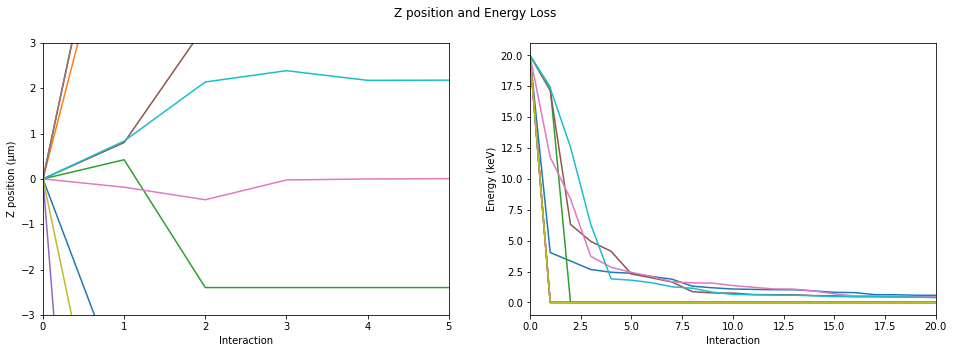

Counted Electrons : 10
Quantity:
Transmitted : 5, Backscattered : 5, Absorbed : 0
Ratios :
Transmitted : 0.500, Backscattered : 0.500, Absorbed : 0.000


In [11]:
# Counting and plotting the simulated electrons for a specific thickness = 0.5µm
Transmitted, Backscattered, Absorbed = Ratios_function(df_Z, df_KE, threshold = 0.5, thickness = 0.5)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
fig.suptitle('Z position and Energy Loss')
ax1.plot(df_Z)
ax1.set_xlabel('Interaction')
ax1.set_ylabel('Z position (µm)')
ax1.set_xlim(0,5)
ax1.set_ylim(-3,3)

ax2.plot(df_KE)
ax2.set_xlabel('Interaction')
ax2.set_ylabel('Energy (keV)')
ax2.set_xlim(0,20)
plt.show()

print('Counted Electrons :', Transmitted + Backscattered + Absorbed)
print('Quantity:')
print(f"Transmitted : {Transmitted}, Backscattered : {Backscattered}, Absorbed : {Absorbed}") 
print('Ratios :')
print(f"Transmitted : {Transmitted/N_electrons:.3f}, Backscattered : {Backscattered/N_electrons:.3f}, Absorbed : {Absorbed/N_electrons:.3f}") 

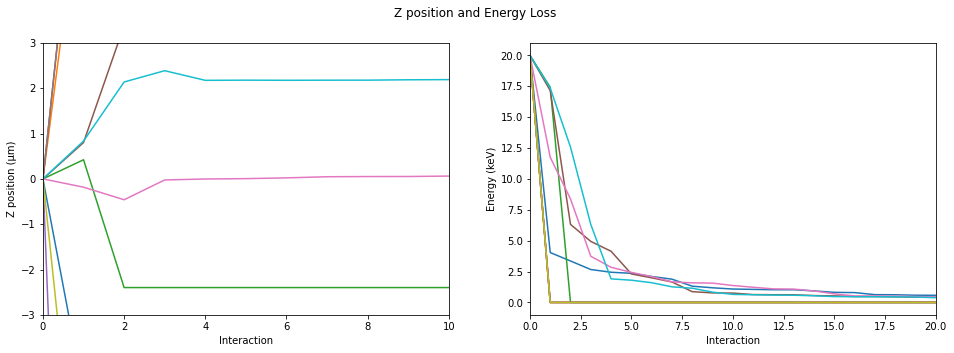

Counted Electrons : 10
Quantity :
Transmitted : 5, Backscattered : 5, Absorbed : 0
Ratios :
Transmitted : 0.50, Backscattered : 0.50, Absorbed : 0.00


In [12]:
# Counting and plotting the simulated electrons for a specific thickness = 1.5µm
Transmitted, Backscattered, Absorbed = Ratios_function(df_Z, df_KE, threshold=0.5, thickness=1.5)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
fig.suptitle('Z position and Energy Loss')
ax1.plot(df_Z)
ax1.set_xlabel('Interaction')
ax1.set_ylabel('Z position (µm)')
ax1.set_xlim(0,10)
ax1.set_ylim(-3,3)

ax2.plot(df_KE)
ax2.set_xlabel('Interaction')
ax2.set_ylabel('Energy (keV)')
ax2.set_xlim(0,20)
plt.show()

print('Counted Electrons :', Transmitted + Backscattered + Absorbed)
print('Quantity :')
print(f"Transmitted : {Transmitted}, Backscattered : {Backscattered}, Absorbed : {Absorbed}") 
print('Ratios :')
print(f"Transmitted : {Transmitted/N_electrons:.2f}, Backscattered : {Backscattered/N_electrons:.2f}, Absorbed : {Absorbed/N_electrons:.2f}") 

In [15]:
" THIS IS A VERIFICATION FUNCTION "
" I've been verifying that my counters are set correctly using this graphs "
def Verify(electron, threshold, thickness, df_Z, df_KE):
    
    Transmitted_count = 0
    Backscattered_count = 0

    for j in range(N_interactions):
        if df_KE[electron][j] == 1e-12 and df_Z[electron][j] < 0:
            Backscattered_count += 1
            break
        if df_KE[electron][j] == 1e-12 and df_Z[electron][j] > thickness:
            Transmitted_count += 1
            break
        if df_Z[electron][j] < 0 and df_KE[electron][j] > threshold:
            Backscattered_count += 1
            break
        if df_Z[electron][j] > thickness and df_KE[electron][j] > threshold:
            Transmitted_count += 1
            break

    # In case the iterations in my code are not long enough to have the kinetic energy reduced bellow the threshold
    Absorbed = 1 - Transmitted_count - Backscattered_count
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))
    fig.suptitle('Verification of Z position and Kinetic Energy')
    ax1.plot(df_Z.iloc[:, electron])
    ax1.set_ylabel('Z position (µm)')
    ax1.set_xlim(0,10)
    ax1.set_xlabel('Interaction')
    ax1.set_ylim(-(thickness + 1), thickness + 1)
    ax1.axhline(y= thickness, color='gray', linestyle='--', alpha=0.5)

    ax2.plot(df_KE.iloc[:, electron])
    ax2.set_ylabel('Kinetic Energy (keV)')
    ax2.set_xlabel('Interaction')
    ax2.set_xlim(0,10)
    plt.show()
    
    return Transmitted_count, Backscattered_count, Absorbed

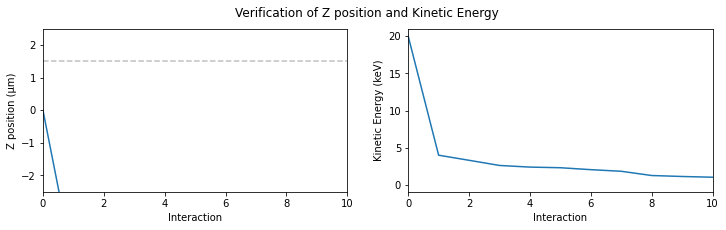

Quantity :
Transmitted : 0, Backscattered : 1, Absorbed : 0


In [16]:
# I would visualize the graphs from above and then look at each electron individually
# I can therefore make sure that its being counted as what I expect it to be

electron = 0
thickness = 1.5
threshold = 0.5 # energy threshold
Transmitted_count, Backscattered_count, Absorbed = Verify(electron, threshold, thickness, df_Z, df_KE)

print('Quantity :')
print(f"Transmitted : {Transmitted_count}, Backscattered : {Backscattered_count}, Absorbed : {Absorbed}") 

## Now to run it again and store the data

On the following, I just ran my loops from above a few times and added the information to a 'results' dataframe, I could've wrote the loops in a function to avoid calling it over and over but I had some problems while doing it and it was taking to much time, so for now I decided to leave it like this.

In [17]:
""" FOR ALUMINUM, THETA = 0 """
N_electrons = 2000
N_interactions = 100

# Material Aluminum
A = 27
rho = 2.7
Z = 13

# Incidence
Theta = 0
Phi = 0


KE = np.zeros((N_interactions + 1, N_electrons))
X_pos = np.zeros((N_interactions + 1, N_electrons))
Y_pos = np.zeros((N_interactions + 1, N_electrons))
Z_pos = np.zeros((N_interactions + 1, N_electrons))
S_travel = np.zeros((N_interactions + 1, N_electrons))

for i in range(N_electrons):
    
    # Initial values, to be added to the begining of the list each time
    KE_old = 20
    x_old, y_old, z_old, s_old = 0,0,0,0
    theta_old, phi_old = Theta, Phi
    
    KE[0][i] = KE_old
    X_pos[0][i] = x_old
    Y_pos[0][i] = y_old
    Z_pos[0][i] = z_old
    S_travel[0][i] = s_old
    
    for j in range(N_interactions):
        
        beta = Beta_function(KE_old)
        theta_new, phi_new = New_angles_function(theta_old, phi_old, beta)
        s_n = S_function(beta, A, KE_old, Z, rho)
        x_new, y_new, z_new = Position_function(x_old, y_old, z_old, s_n, theta_new, phi_new)
        KE_new = Kinetic_energy_function(s_n, A, KE_old, Z, rho) 
        
        if KE_new < 0:
            KE_new = 1e-12

        # Update the values in each iteration
        KE_old = KE_new
        theta_old, phi_old = theta_new, phi_new
        x_old, y_old, z_old = x_new, y_new, z_new

        # Save the wanted value in the list
        KE[j+1][i] = KE_new
        X_pos[j+1][i] = x_new
        Y_pos[j+1][i] = y_new
        Z_pos[j+1][i] = z_new
        S_travel[j+1][i] = s_n
    

# Creating the corresponding DataFrames
df_KE = pd.DataFrame(KE)
df_X = pd.DataFrame(X_pos)
df_Y = pd.DataFrame(Y_pos)
df_Z = pd.DataFrame(Z_pos)
df_S = pd.DataFrame(S_travel)

In [18]:
# RESULTS


""" JUST RUN IT ONE TIME FOR THE INITIAL ROW """

threshold = 0.5
thickness = 0.5
Transmitted, Backscattered, Absorbed = Ratios_function(df_Z, df_KE, threshold, thickness)

columns = ['Material','Thickness (µm)','Angle', 'Backscattered (R)', 'Transmitted (T)', 'Absorbed (A)']
df_results = pd.DataFrame(columns=columns)

# Define the row to be added
new_row = {'Material': 'Aluminum',  
           'Thickness (µm)': thickness,
           'Angle': Theta,
           'Backscattered (R)': Backscattered/N_electrons,
           'Transmitted (T)': Transmitted/N_electrons,
           'Absorbed (A)': Absorbed/N_electrons}

# Add the initial row to the DataFrame
df_results.loc[len(df_results)] = new_row
df_results

,Material,Thickness (µm),Angle,Backscattered (R),Transmitted (T),Absorbed (A)
0,Aluminum,0.5,0,0.2,0.7775,0.0225


In [19]:
""" RUN THIS FOR THE FOLLOWING ROWS (RESULTS)"""
threshold = 0.5
thickness = 1.5
Transmitted, Backscattered, Absorbed = Ratios_function(df_Z, df_KE, threshold, thickness)

new_list = ['Aluminum', thickness , Theta , Backscattered/N_electrons, Transmitted/N_electrons, Absorbed/N_electrons]
df_results.loc[len(df_results)] = new_list
df_results

,Material,Thickness (µm),Angle,Backscattered (R),Transmitted (T),Absorbed (A)
0,Aluminum,0.5,0,0.200,0.7775,0.0225
1,Aluminum,1.5,0,0.228,0.6825,0.0895


In [20]:
" FOR ALUMINUM THETA = 45"
N_electrons = 2000
N_interactions = 100

# Material
A = 27
rho = 2.7
Z = 13

# Incidence
Theta = 45
Phi = 0

KE = np.zeros((N_interactions + 1, N_electrons))
X_pos = np.zeros((N_interactions + 1, N_electrons))
Y_pos = np.zeros((N_interactions + 1, N_electrons))
Z_pos = np.zeros((N_interactions + 1, N_electrons))
S_travel = np.zeros((N_interactions + 1, N_electrons))

for i in range(N_electrons):
    
    # Initial values, to be added to the begining of the list each time
    KE_old = 20
    x_old, y_old, z_old, s_old = 0,0,0,0
    theta_old, phi_old = Theta, Phi
    
    KE[0][i] = KE_old
    X_pos[0][i] = x_old
    Y_pos[0][i] = y_old
    Z_pos[0][i] = z_old
    S_travel[0][i] = s_old
    
    for j in range(N_interactions):
        
        beta = Beta_function(KE_old)
        theta_new, phi_new = New_angles_function(theta_old, phi_old, beta)
        s_n = S_function(beta, A, KE_old, Z, rho)
        x_new, y_new, z_new = Position_function(x_old, y_old, z_old, s_n, theta_new, phi_new)
        KE_new = Kinetic_energy_function(s_n, A, KE_old, Z, rho) 
        
        if KE_new < 0:
            KE_new = 1e-12

        # Update the values in each iteration
        KE_old = KE_new
        theta_old, phi_old = theta_new, phi_new
        x_old, y_old, z_old = x_new, y_new, z_new

        # Save the wanted value in the list
        KE[j+1][i] = KE_new
        X_pos[j+1][i] = x_new
        Y_pos[j+1][i] = y_new
        Z_pos[j+1][i] = z_new
        S_travel[j+1][i] = s_n
    

# Creating the corresponding DataFrames
df_KE = pd.DataFrame(KE)
df_X = pd.DataFrame(X_pos)
df_Y = pd.DataFrame(Y_pos)
df_Z = pd.DataFrame(Z_pos)
df_S = pd.DataFrame(S_travel)

In [21]:
""" RUN THIS FOR THE FOLLOWING ROWS (RESULTS)"""
threshold = 0.5
thickness = 0.5
Transmitted, Backscattered, Absorbed = Ratios_function(df_Z, df_KE, threshold, thickness)

new_list = ['Aluminum', thickness , Theta , Backscattered/N_electrons, Transmitted/N_electrons, Absorbed/N_electrons]
df_results.loc[len(df_results)] = new_list

threshold = 0.5
thickness = 1.5
Transmitted, Backscattered, Absorbed = Ratios_function(df_Z, df_KE, threshold, thickness)

new_list = ['Aluminum', thickness , Theta , Backscattered/N_electrons, Transmitted/N_electrons, Absorbed/N_electrons]
df_results.loc[len(df_results)] = new_list
df_results

,Material,Thickness (µm),Angle,Backscattered (R),Transmitted (T),Absorbed (A)
0,Aluminum,0.5,0,0.200,0.7775,0.0225
1,Aluminum,1.5,0,0.228,0.6825,0.0895
2,Aluminum,0.5,45,0.334,0.6420,0.0240
3,Aluminum,1.5,45,0.354,0.5425,0.1035


In [22]:
" FOR GOLD,  THETA = 0"
N_electrons = 2000
N_interactions = 100

# Material GOLD
A = 197
rho = 19.3
Z = 79

# Incidence
Theta = 0
Phi = 0

KE = np.zeros((N_interactions + 1, N_electrons))
X_pos = np.zeros((N_interactions + 1, N_electrons))
Y_pos = np.zeros((N_interactions + 1, N_electrons))
Z_pos = np.zeros((N_interactions + 1, N_electrons))
S_travel = np.zeros((N_interactions + 1, N_electrons))

for i in range(N_electrons):
    
    # Initial values, to be added to the begining of the list each time
    KE_old = 20
    x_old, y_old, z_old, s_old = 0,0,0,0
    theta_old, phi_old = Theta, Phi
    
    KE[0][i] = KE_old
    X_pos[0][i] = x_old
    Y_pos[0][i] = y_old
    Z_pos[0][i] = z_old
    S_travel[0][i] = s_old
    
    for j in range(N_interactions):
        
        beta = Beta_function(KE_old)
        theta_new, phi_new = New_angles_function(theta_old, phi_old, beta)
        s_n = S_function(beta, A, KE_old, Z, rho)
        x_new, y_new, z_new = Position_function(x_old, y_old, z_old, s_n, theta_new, phi_new)
        KE_new = Kinetic_energy_function(s_n, A, KE_old, Z, rho) 
        
        if KE_new < 0:
            KE_new = 1e-12

        # Update the values in each iteration
        KE_old = KE_new
        theta_old, phi_old = theta_new, phi_new
        x_old, y_old, z_old = x_new, y_new, z_new

        # Save the wanted value in the list
        KE[j+1][i] = KE_new
        X_pos[j+1][i] = x_new
        Y_pos[j+1][i] = y_new
        Z_pos[j+1][i] = z_new
        S_travel[j+1][i] = s_n
    

# Creating the corresponding DataFrames
df_KE = pd.DataFrame(KE)
df_X = pd.DataFrame(X_pos)
df_Y = pd.DataFrame(Y_pos)
df_Z = pd.DataFrame(Z_pos)
df_S = pd.DataFrame(S_travel)

In [23]:
""" RUN THIS FOR THE FOLLOWING ROWS (RESULTS)"""
threshold = 0.5
thickness = 0.1
Transmitted, Backscattered, Absorbed = Ratios_function(df_Z, df_KE, threshold, thickness)

new_list = ['Gold', thickness , Theta , Backscattered/N_electrons, Transmitted/N_electrons, Absorbed/N_electrons]
df_results.loc[len(df_results)] = new_list

threshold = 0.5
thickness = 0.2
Transmitted, Backscattered, Absorbed = Ratios_function(df_Z, df_KE, threshold, thickness)

new_list = ['Gold', thickness , Theta , Backscattered/N_electrons, Transmitted/N_electrons, Absorbed/N_electrons]
df_results.loc[len(df_results)] = new_list
df_results

,Material,Thickness (µm),Angle,Backscattered (R),Transmitted (T),Absorbed (A)
0,Aluminum,0.5,0,0.2000,0.7775,0.0225
1,Aluminum,1.5,0,0.2280,0.6825,0.0895
2,Aluminum,0.5,45,0.3340,0.6420,0.0240
3,Aluminum,1.5,45,0.3540,0.5425,0.1035
4,Gold,0.1,0,0.3290,0.6690,0.0020
5,Gold,0.2,0,0.3995,0.5560,0.0445


In [24]:
" FOR GOLD,  THETA = 45"
N_electrons = 2000
N_interactions = 100

# Material GOLD
A = 197
rho = 19.3
Z = 79

# Incidence
Theta = 45
Phi = 0

KE = np.zeros((N_interactions + 1, N_electrons))
X_pos = np.zeros((N_interactions + 1, N_electrons))
Y_pos = np.zeros((N_interactions + 1, N_electrons))
Z_pos = np.zeros((N_interactions + 1, N_electrons))
S_travel = np.zeros((N_interactions + 1, N_electrons))

for i in range(N_electrons):
    
    # Initial values, to be added to the begining of the list each time
    KE_old = 20
    x_old, y_old, z_old, s_old = 0,0,0,0
    theta_old, phi_old = Theta, Phi
    
    KE[0][i] = KE_old
    X_pos[0][i] = x_old
    Y_pos[0][i] = y_old
    Z_pos[0][i] = z_old
    S_travel[0][i] = s_old
    
    for j in range(N_interactions):
        
        beta = Beta_function(KE_old)
        theta_new, phi_new = New_angles_function(theta_old, phi_old, beta)
        s_n = S_function(beta, A, KE_old, Z, rho)
        x_new, y_new, z_new = Position_function(x_old, y_old, z_old, s_n, theta_new, phi_new)
        KE_new = Kinetic_energy_function(s_n, A, KE_old, Z, rho) 
        
        if KE_new < 0:
            KE_new = 1e-12

        # Update the values in each iteration
        KE_old = KE_new
        theta_old, phi_old = theta_new, phi_new
        x_old, y_old, z_old = x_new, y_new, z_new

        # Save the wanted value in the list
        KE[j+1][i] = KE_new
        X_pos[j+1][i] = x_new
        Y_pos[j+1][i] = y_new
        Z_pos[j+1][i] = z_new
        S_travel[j+1][i] = s_n
    

# Creating the corresponding DataFrames
df_KE = pd.DataFrame(KE)
df_X = pd.DataFrame(X_pos)
df_Y = pd.DataFrame(Y_pos)
df_Z = pd.DataFrame(Z_pos)
df_S = pd.DataFrame(S_travel)

In [25]:
""" RUN THIS FOR THE FOLLOWING ROWS (RESULTS)"""
threshold = 0.5
thickness = 0.1
Transmitted, Backscattered, Absorbed = Ratios_function(df_Z, df_KE, threshold, thickness)

new_list = ['Gold', thickness , Theta , Backscattered/N_electrons, Transmitted/N_electrons, Absorbed/N_electrons]
df_results.loc[len(df_results)] = new_list

threshold = 0.5
thickness = 0.2
Transmitted, Backscattered, Absorbed = Ratios_function(df_Z, df_KE, threshold, thickness)

new_list = ['Gold', thickness , Theta , Backscattered/N_electrons, Transmitted/N_electrons, Absorbed/N_electrons]
df_results.loc[len(df_results)] = new_list
df_results

,Material,Thickness (µm),Angle,Backscattered (R),Transmitted (T),Absorbed (A)
0,Aluminum,0.5,0,0.2000,0.7775,0.0225
1,Aluminum,1.5,0,0.2280,0.6825,0.0895
2,Aluminum,0.5,45,0.3340,0.6420,0.0240
3,Aluminum,1.5,45,0.3540,0.5425,0.1035
4,Gold,0.1,0,0.3290,0.6690,0.0020
5,Gold,0.2,0,0.3995,0.5560,0.0445
6,Gold,0.1,45,0.4595,0.5370,0.0035
7,Gold,0.2,45,0.5210,0.4330,0.0460


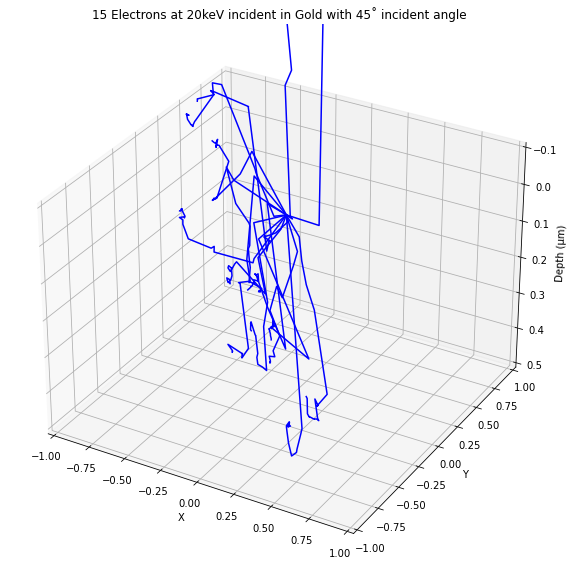

In [26]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

tracks=15
for i in range(tracks):
    ax.plot3D(df_X[i][0:20], df_Y[i][0:20], df_Z[i][0:20], 'blue')
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.set_zlim(-0.1,0.5)
ax.set_title('15 Electrons at 20keV incident in Gold with 45˚ incident angle')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Depth (µm)')
ax.invert_zaxis()

plt.show()

In [27]:
# Theoretical 
data = {'Material': ['Aluminum','Aluminum','Aluminum','Aluminum','Gold','Gold','Gold','Gold'],
           'Thickness (µm)': [0.5,1.5,0.5,1.5,0.1,0.2,0.1,0.2],
           'Angle': [0,0,45,45,0,0,45,45],
           'Backscattered (R)': [0.03, 0.16, 0.19, 0.22, 0.35,0.525,0.535,0.49],
           'Transmitted (T)': [0.965, 0.601, 0.805, 0.5,0.646,0.305,0.455,0.3],
           'Absorbed (A)': [0.005, 0.235, 0.005, 0.28,0.005,0.17,0.01,0.21]}

df_theoretical = pd.DataFrame(data)
df_theoretical



,Material,Thickness (µm),Angle,Backscattered (R),Transmitted (T),Absorbed (A)
0,Aluminum,0.5,0,0.030,0.965,0.005
1,Aluminum,1.5,0,0.160,0.601,0.235
2,Aluminum,0.5,45,0.190,0.805,0.005
3,Aluminum,1.5,45,0.220,0.500,0.280
4,Gold,0.1,0,0.350,0.646,0.005
5,Gold,0.2,0,0.525,0.305,0.170
6,Gold,0.1,45,0.535,0.455,0.010
7,Gold,0.2,45,0.490,0.300,0.210


In [28]:
Backscattered_error = np.abs((df_results['Backscattered (R)'][0:8] 
                              - df_theoretical['Backscattered (R)'][0:8]) * 100 
                             / df_theoretical['Backscattered (R)'][0:8])
Transmitted_error = np.abs((df_results['Transmitted (T)'][0:8] 
                            - df_theoretical['Transmitted (T)'][0:8]) * 100 
                           / df_theoretical['Transmitted (T)'][0:8])
Absorbed_error = np.abs((df_results['Absorbed (A)'][0:8] 
                         - df_theoretical['Absorbed (A)'][0:8]) * 100 
                        / df_theoretical['Absorbed (A)'][0:8])

## Conclusions

My results are far from the theoretical values, there is a lot of contribution from the backscattering.
In general, the results from gold are much in line with what's expected than the results from aluminum.

I suspect that the mistake comes mainly from the functions to calculate new angles. 